# Definitions

## Import packages and define derived fields

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import yt
# import seaborn as sns

plt.style.use('../plot_scripts/plot_style.mplstyle')

import para_scan as ps
import v_turb as vt
import tgrow as tg

In [8]:
from yt import derived_field

CONST_pc  = 3.086e18
CONST_yr  = 3.154e7
CONST_amu = 1.66053886e-24
CONST_kB  = 1.3806505e-16
unit_length = CONST_pc*1e3  # 1 kpc
unit_time   = CONST_yr*1e6  # 1 Myr
unit_density = CONST_amu    # 1 mp/cm-3
unit_velocity = unit_length/unit_time
KELVIN = unit_velocity*unit_velocity*CONST_amu/CONST_kB

g = 5/3
# T_floor = 10000.0
T_ceil = 1e8

Xsol = 1.0
Zsol = 1.0

X = Xsol * 0.7381
Z = Zsol * 0.0134
Y = 1 - X - Z

mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
mue = 2.0/(1.0+X);
muH = 1.0/X;

mH = 1.0


# Temperature in Kelvin
@derived_field(name="temp", units="code_length**3*code_pressure/code_mass", \
    sampling_type="cell",force_override=True)
def _temp(field, data):
    return (data["gas", "pressure"] / data["gas", "density"]) * KELVIN * mu

@derived_field(name="mom1", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom1(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel1'])

@derived_field(name="mom2", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom2(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel2'])

@derived_field(name="mom3", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom3(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel3'])

## Class hst_data definitions

In [34]:
class hst_data:

    def __init__(self, fn, ncells, MHD_flag=False):

        """Read hst and return structured numpy dict.
        Keyword Arguments:
        fn -- 
        """

        hdr = []
        with open(fn, 'r') as fp:
            while True:
                l = fp.readline()
                if l[0] != '#':
                    raise Exception("No header in %s found!" %(fn))
                if '[1]' in l:
                    hdr = [i.split("=")[1].strip() for i in l[1:].split("[") if ']' in i]
                    print('It worked!',fn)
                    break

        r = np.loadtxt(fn, dtype={'names' : hdr, 'formats' : len(hdr) * (float,)})

        self.dict = r

        self.time  = self.dict['time']
        self.dt    = self.dict['dt']

        self.mass_tot  = self.dict['mass']

        self.mom1  = self.dict['1-mom']
        self.mom2  = self.dict['2-mom']
        self.mom3  = self.dict['3-mom']

        self.KE1   = self.dict['1-KE']
        self.KE2   = self.dict['2-KE']
        self.KE3   = self.dict['3-KE']
        self.E_tot = self.dict['tot-E']

        self.ME1   = self.dict['1-ME']
        self.ME2   = self.dict['2-ME']
        self.ME3   = self.dict['3-ME']

        self.cold_gas = self.dict['cold_gas']

        self.rho_avg    = self.dict['rho_sum']/ncells
        self.rho_sq_avg = self.dict['rho_sq_sum']/ncells

        self.cs_avg    = self.dict['c_s_sum']/ncells
        self.tcool_avg = self.dict['tcool_sum']/ncells

        if MHD_flag:

            self.Pth_avg = self.dict['Pth_sum']/ncells
            self.PB_avg  = self.dict['PB_sum']/ncells
            self.Bx_avg  = self.dict['Bx_sum']/ncells
            self.By_avg  = self.dict['By_sum']/ncells
            self.Bz_avg  = self.dict['Bz_sum']/ncells

            self.B_abs_avg = np.sqrt(self.PB_avg*2)
            self.dB = np.roll(self.B_abs_avg,-1) - self.B_abs_avg
            self.dt = self.time[1] - self.time[0]

            self.va = self.B_abs_avg/np.sqrt(self.rho_avg)


        self.KE_tot = self.KE1+self.KE2+self.KE3
        self.turb_vel = np.sqrt(self.KE_tot*2/self.mass_tot)

        self.clumping_factor = self.rho_sq_avg/self.rho_avg**2
        self.cold_gas_fraction = self.cold_gas/self.mass_tot

        

        
        

# File reading function

In [10]:
M = 0.5
v_turb_predict = M*vt.cs_calc(ps.T_hot_req,ps.mu)
t_eddy = ps.L_box/v_turb_predict


In [29]:
def hst_read (file_name,Rlsh,res,rseed,beta,M):
    if file_name == 'mhd':
        file_path = f'para_scan_Rlsh{i_r}_{Rlsh}_res0_{res}_rseed_{rseed}_M_{M}_chi_100_beta_{beta}/Turb.hst'
        MHD_flag  = True
    else:
        file_path = f'para_scan_Rlsh{i_r}_{Rlsh}_res0_{res}_rseed_{rseed}_M_{M}_chi_100_hydro/Turb.hst'
        MHD_flag  = False


    print(f'{file_path}')
    hst = hst_data(file_path,res**3,MHD_flag)

    return hst, file_path, MHD_flag

In [30]:
import matplotlib as mt
import scipy.signal as sg
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import linregress

# beta_list = np.array([1,2,5,10,100,1000])
beta_list = np.array([100])
# Rlsh_list = np.array([2500,0,0,0,0])
# Rlsh_list = np.array([100,250,500,1000,2500])
Rlsh_list = np.array([100,250,500,1000,2500, 50, 10, 5, 2, 1])
# Rlsh_list = np.array([100,750,1000,2500])
# res_list  = np.array([128,256,512])
res_list  = np.array([128])
# res_list  = np.array([256])
# res_list  = np.array([64])
# res_list  = np.array([512])

v_turb_sim = np.zeros(np.size(Rlsh_list))

# cmap_name = 'viridis'
cmap_name = 'Paired'

cmap = mt.cm.get_cmap(cmap_name)

# cb_qnt = np.scopy(ps.dedt)
cb_qnt = np.copy(Rlsh_list)

# line_col = cmap(np.log10(beta_list)/np.log10(beta_list).max())
line_col = cmap(cb_qnt/cb_qnt.max())

# file_list = ['hydro']
# file_list = ['mhd']
file_list = ['mhd','hydro']
rseed_list = [1]
linestyle_list = ['solid','dashed']
# linestyle_list = ['dashed','solid']

marker_list_hyd = ['X','o','D','^','v']
marker_list_mhd = ['o','D','^','v','X']

gamma = 5/3


# v_turb vs time plot

para_scan_Rlsh0_100_res0_256_rseed_1_hydro/Turb.hst
para_scan_Rlsh1_250_res0_256_rseed_1_hydro/Turb.hst
para_scan_Rlsh2_500_res0_256_rseed_1_hydro/Turb.hst
para_scan_Rlsh3_1000_res0_256_rseed_1_hydro/Turb.hst
para_scan_Rlsh4_2500_res0_256_rseed_1_hydro/Turb.hst


Text(0.5, 1.0, 'Resolution: 256$^3$')

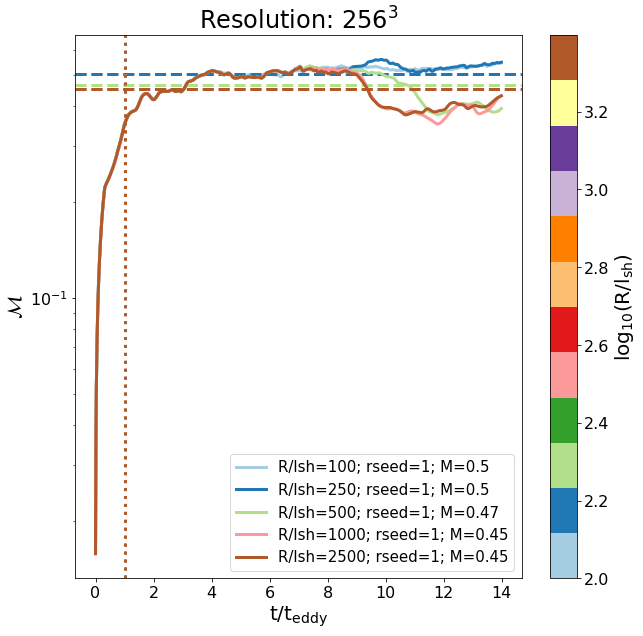

In [31]:
fig1, ax1 = plt.subplots(1,1,figsize=(10,10))


for i_fl,file_name in enumerate(file_list):
    for i_b, beta in enumerate(beta_list):
        for i_r, Rlsh in enumerate(Rlsh_list):
            for res in res_list:
                for rseed in rseed_list:


                    try:
                        hst, file_path,MHD_flag, success_flag = hst_read(file_name,Rlsh,res,rseed,beta,M)
                        # print(file_path)
                    except:
                        print(f'File for {file_name},Rlsh_{Rlsh},res_{res},rseed_{rseed},beta_{beta} does not exist !')
                        continue

                    # print(file_path,res**3,MHD_flag)

                    v_turb_tcut = 1

                    cs = vt.cs_calc(ps.T_hot_req,ps.mu)

                    v_turb_sim[i_r]  = np.average(hst.turb_vel[hst.time/t_eddy[i_r] > v_turb_tcut]/cs)

                    t_eddy_actual = ps.L_box[i_r]/(v_turb_sim[i_r]*cs)
                    
                    
                    ax1.axvline(v_turb_tcut,color = line_col[i_r],linestyle='dotted')

                    ax1.plot(hst.time[:-1]/t_eddy[i_r],hst.turb_vel[:-1]/cs, color = line_col[i_r], linestyle=linestyle_list[i_fl],\
                        label=f'R/lsh={Rlsh_list[i_r]}; rseed={rseed}; M={v_turb_sim[i_r]:.2}')
                    ax1.axhline(v_turb_sim[i_r],color=line_col[i_r], linestyle='dashed')


sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=np.log10(cb_qnt).min(), vmax=np.log10(cb_qnt).max()))
plt.colorbar(sm, ax=ax1, label=r'log$_{10}$(R/l$_{\rm sh}$)')

ax1.legend(loc='lower right')

ax1.set_ylabel(r'$\mathcal{M}$')
ax1.set_xlabel(r't/t$_{\rm eddy}$')

ax1.set_yscale('log')

ax1.set_title('Resolution: '+f'{res}'+r'$^3$')


# Cold mass vs time plot

para_scan_Rlsh0_100_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
It worked! para_scan_Rlsh0_100_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
File for mhd,Rlsh_100,res_128,rseed_1,beta_100 does not exist !
para_scan_Rlsh1_250_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
It worked! para_scan_Rlsh1_250_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
File for mhd,Rlsh_250,res_128,rseed_1,beta_100 does not exist !
para_scan_Rlsh2_500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
It worked! para_scan_Rlsh2_500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
File for mhd,Rlsh_500,res_128,rseed_1,beta_100 does not exist !
para_scan_Rlsh3_1000_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
It worked! para_scan_Rlsh3_1000_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
File for mhd,Rlsh_1000,res_128,rseed_1,beta_100 does not exist !
para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst
It worked! para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Tur

No handles with labels found to put in legend.


Text(0.5, 1.0, 'M= 0.5, Resolution: 128$^3$')

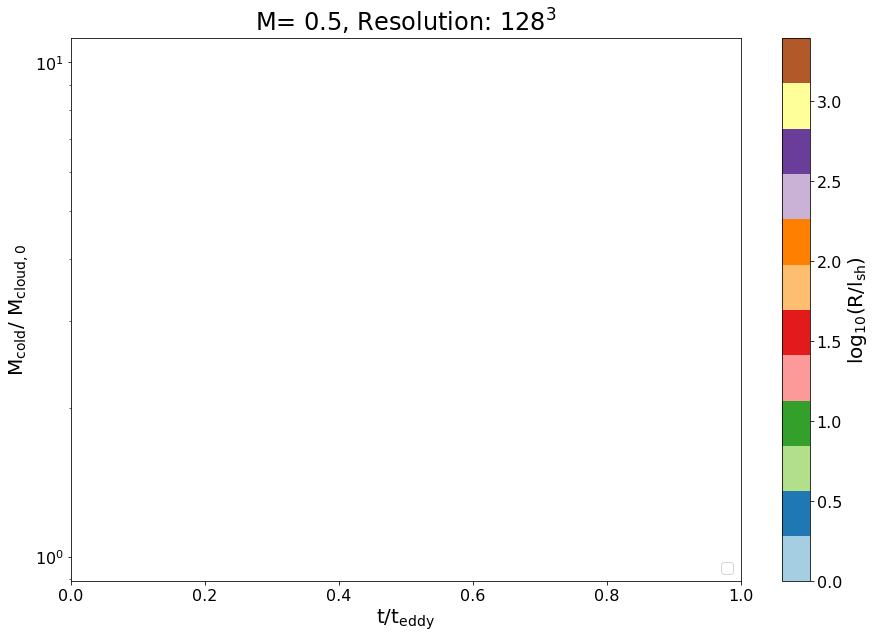

In [36]:
fig2, ax2 = plt.subplots(1,1,figsize=(15,10))


for i_fl,file_name in enumerate(file_list):
    for i_b, beta in enumerate(beta_list):
        for i_r, Rlsh in enumerate(Rlsh_list):
            for res in res_list:
                for rseed in rseed_list:


                    try:
                        hst, file_path,MHD_flag = hst_read(file_name,Rlsh,res,rseed,beta,M)
                    except:
                        print(f'File for {file_name},Rlsh_{Rlsh},res_{res},rseed_{rseed},beta_{beta} does not exist !')
                        continue

                    # print(file_path,res**3,MHD_flag)

                    Chi = ps.cloud_chi
                    Rcl_lsh = Rlsh
                    Rcl_Lbox = ps.L_box[i_r]/ps.cloud_radius[i_r]

                    tgrow = np.vectorize(tg.tgrow)(Chi, v_turb_sim[i_r], Rcl_lsh, Rcl_Lbox, ps.t_cool_cloud)

                    Lbox_rad = np.average(ps.L_box/ps.cloud_radius)
                    r_N = res/Lbox_rad

                    dM_min = 1/(r_N**3)


                    cloud_mass = 4/3 * np.pi * (ps.cloud_radius[i_r]**3) * ps.amb_rho * ps.cloud_chi
                    
                    y_data2 = np.copy(hst.cold_gas)[hst.cold_gas_fraction<0.25]
                    # y_data2 = np.copy(hst.cold_gas)
                    # y_data2 = sg.savgol_filter(y_data2, window_length=51, polyorder=3)

                    x_data2 = np.copy(hst.time/t_eddy[i_r])[hst.cold_gas_fraction<0.25]
                
                    y_data2 = y_data2[x_data2>7.1]
                    x_data2 = x_data2[x_data2>7.1]
                    
                    window_size = 35

                    # y_data2 = y_data2[x_data2<11]
                    # x_data2 = x_data2[x_data2<11]

                    # if len(y_data2)<=window_size:
                    #     break
                    
                    print(y_data2[0])

                    y_data2_unsmooth = y_data2 /(y_data2[0])
                    y_data2          = np.copy(y_data2_unsmooth)

                    # x_data2 = x_data2[y_data2>1e-3]
                    # y_data2 = y_data2[y_data2>1e-3]

                    # x_data2 = x_data2[y_data2<10]
                    # y_data2 = y_data2[y_data2<10]

                    # y_data2 = sg.savgol_filter(y_data2, window_length=window_size, polyorder=3)
                    
                    if not(MHD_flag):

                        # pass

                        y_data2 = sg.savgol_filter(y_data2, window_length=window_size, polyorder=3)
                        
                        ax2.plot(x_data2, y_data2, '-'+marker_list_hyd[i_r], markevery=25, markersize=15, markeredgecolor='k',\
                            color = line_col[i_r], linestyle=linestyle_list[i_fl],label=f'R/lsh={Rlsh_list[i_r]}_hyd', linewidth=5,\
                            zorder=-i_r)

                        # ax2.plot( x_data2, np.exp((x_data2-x_data2[0])/tgrow) , linestyle='dotted', color = line_col[i_r])

                    else:
                        pass

                        # y_data2 = sg.savgol_f/ilter(y_data2, window_length=window_size, polyorder=3)

                        # ax2.plot(x_data2, y_data2, '-'+marker_list_mhd[i_r], markevery=25, markersize=15, markeredgecolor='k',\
                        #     color = line_col[i_r], linestyle=linestyle_list[i_fl],label=f'R/lsh={Rlsh_list[i_r]}', linewidth=5,\
                        #     zorder=-i_r)
                    


sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=np.log10(cb_qnt).min(), vmax=np.log10(cb_qnt).max()))
plt.colorbar(sm, ax=ax2, label=r'log$_{10}$(R/l$_{\rm sh}$)')

ax2.legend(loc='lower right')

ax2.set_ylabel(r'M$_{\rm cold}$/ M$_{\rm cloud,0}$')
ax2.set_xlabel(r't/t$_{\rm eddy}$')

ax2.set_yscale('log')

# ax2.set_ylim(1e-3,2e2)

ax2.set_title(f'M= {M}, Resolution: {res}'+r'$^3$')

para_scan_Rlsh0_100_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh1_250_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh2_500_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh3_1000_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh4_2500_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh0_100_res0_128_rseed_1_hydro/Turb.hst
para_scan_Rlsh1_250_res0_128_rseed_1_hydro/Turb.hst
para_scan_Rlsh2_500_res0_128_rseed_1_hydro/Turb.hst
para_scan_Rlsh3_1000_res0_128_rseed_1_hydro/Turb.hst
para_scan_Rlsh4_2500_res0_128_rseed_1_hydro/Turb.hst


Text(0.5, 1.0, 'M= 0.5, Resolution: 128$^3$')

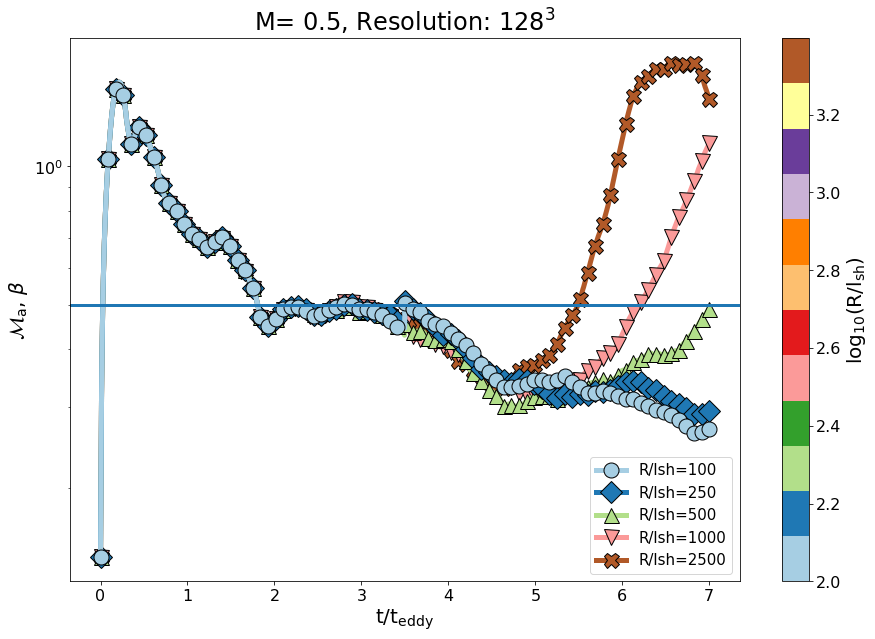

In [31]:
fig3, ax3 = plt.subplots(1,1,figsize=(15,10))


for i_fl,file_name in enumerate(file_list):
    for i_b, beta in enumerate(beta_list):
        for i_r, Rlsh in enumerate(Rlsh_list):
            for res in res_list:
                for rseed in rseed_list:

                    try:
                        hst, file_path,MHD_flag, success_flag = hst_read(file_name,Rlsh,res,rseed,beta,M)
                    except:
                        print(f'File for {file_name},Rlsh_{Rlsh},res_{res},rseed_{rseed},beta_{beta} does not exist !')
                        continue

                    # print(file_path,res**3,MHD_flag)

                    if not(MHD_flag):
                        continue
                    
                    # y_data3 = hst.cs_avg # hst.Pth_avg/hst.PB_avg
                    # y_data3 = hst.PB_avg/hst.Pth_avg
                    # y_data3 = 1/y_data3
                    y_data3 = hst._vel*2***2*2s.cs_avg****2


                    # y_data3 = (hst.Pth_avg / hst.rho_avg) * KELVIN * mu
                    # y_data3 = hst.B_abs_avg**2/2
                    # y_data3 = 0.5* hst.turb_vel**2 * hst.rho_avg / (hst.B_abs_avg**2/2)
                    # y_data3 = hst.PB_avg

                    x_data3 = np.copy(hst.time/t_eddy[i_r])

                    # y_data4 = np.sqrt( gamma*hst.Pth_avg/hst.rho_avg) # hst.turb_vel/hst.va
                    # y_data4 = 0.5 * hst.rho_avg * hst.turb_vel**2
                    # y_data4 = y_data4/hst.Pth_avg
                    y_data4 = gamma/2  *  M**2 # turb_vel**2 / hst.cs_avg**2
                    y_data4 = 1/y_data4
                    # y_data3 = y_data3[x_data3<7]
                    # y_data4 = y_data4[x_data3<7]                    
                    # x_data3 = x_data3[x_data3<7]


                    ax3.plot(x_data3, y_data3, '-'+marker_list_mhd[i_r], markevery=25, markersize=15, markeredgecolor='k',\
                        color = line_col[i_r], linestyle=linestyle_list[i_fl],label=f'R/lsh={Rlsh_list[i_r]}', linewidth=5,\
                        zorder=-i_r)

                    # ax3.plot(x_data3, y_data4,\
                    #     color = line_col[i_r], linestyle=linestyle_list[i_fl], linewidth=5,\
                    #     zorder=-i_r)
                
                    # N_in = 1250

                    # t_in    = x_data3[N_in]
                    # beta_in = y_data3[N_in]

                    # ax3.axvline(t_in)
                    # ax3.axhline(beta_in)
                    
                    # Ma = np.sqrt(gamma/2 * beta_in * M**2)

                    # ax3.axhline(Ma)

                    # ax3.plot(gamma*hst.Pth_avg/hst.rho_avg)

                    ax3.axhline(y_data4)


sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=np.log10(cb_qnt).min(), vmax=np.log10(cb_qnt).max()))
plt.colorbar(sm, ax=ax3, label=r'log$_{10}$(R/l$_{\rm sh}$)')



ax3.set_ylabel(r'$\mathcal{M}_{\rm a}$'+ ', ' +r'$\beta$')
ax3.set_xlabel(r't/t$_{\rm eddy}$')

ax3.set_yscale('log')

# ax3.axhline(1.0, linestyle='dashed', color='k', label=r'$\mathcal{M}_{\rm a} = 1$')
# ax3.axhline(2/(gamma * M**2), linestyle='dotted', color='k', label=r'$\beta = 1/\mathcal{M}_{\rm s}^{2}$')

# ax3.axhline(ps.T_hot_req)

# ax3.set_ylim(1e-3,2e2)

# ax3.axhline(vt.cs_calc(ps.T_hot_req,ps.mu),color='k')

ax3.legend(loc='lower right')

ax3.set_title(f'M= {M}, Resolution: {res}'+r'$^3$')

## Survival plots

In [8]:
from matplotlib.lines import Line2D

M_arr = [0.25,0.5,0.9]

survival = []
Mach_list = []
R_list = []
MHD_flag_list = []

for i_m, m in enumerate(M_arr):


    for i_fl,file_name in enumerate(file_list):
        for i_b, beta in enumerate(beta_list):
            for i_r, Rlsh in enumerate(Rlsh_list):
                for res in res_list:
                    for rseed in rseed_list:


                        v_turb_predict = m*vt.cs_calc(ps.T_hot_req,ps.mu)
                        t_eddy_m = Rlsh*ps.l_sh*40/v_turb_predict

                        try:
                            hst, file_path,MHD_flag, success_flag = hst_read(file_name,Rlsh,res,rseed,beta,m)
                        except:
                            print(f'File for {file_name},Rlsh_{Rlsh},res_{res},rseed_{rseed},beta_{beta} does not exist !')
                            continue


                        y_data5 = np.copy(hst.cold_gas)
                        x_data5 = np.copy(hst.time/t_eddy_m)

                        y_data5 = y_data5[x_data5>7.1]
                        x_data5 = x_data5[x_data5>7.1]
                        
                        y_data5 = y_data5/(y_data5[0])

                        # y_data5 = y_data5[x_data5>10]
                        # x_data5 = x_data5[x_data5>10]

                        R_list.append(Rlsh)
                        Mach_list.append(m)
                        MHD_flag_list.append(MHD_flag)

                        surv_cut = 0.5 

                        if y_data5[-1]>surv_cut:
                            survival.append(True)
                        else:
                            survival.append(False)

# survival = np.array(survival)

MHD_mark = ['D' if s==True else 'o' for s in MHD_flag_list]
MHD_size = [100  if s==True else 450 for s in MHD_flag_list]
MHD_zord = [1   if s==True else -1 for s in MHD_flag_list]

surv_col = ['tab:blue' if s==True else 'tab:red' for s in survival]

# survival[survival==True ] = 'tab:blue'
# survival[survival==False] = 'tab:red'



para_scan_Rlsh0_100_res0_128_rseed_1_M_0.25_beta_100/Turb.hst
para_scan_Rlsh1_250_res0_128_rseed_1_M_0.25_beta_100/Turb.hst
para_scan_Rlsh2_500_res0_128_rseed_1_M_0.25_beta_100/Turb.hst
para_scan_Rlsh3_1000_res0_128_rseed_1_M_0.25_beta_100/Turb.hst
para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.25_beta_100/Turb.hst
para_scan_Rlsh0_100_res0_128_rseed_1_M_0.25_hydro/Turb.hst
para_scan_Rlsh1_250_res0_128_rseed_1_M_0.25_hydro/Turb.hst
para_scan_Rlsh2_500_res0_128_rseed_1_M_0.25_hydro/Turb.hst
para_scan_Rlsh3_1000_res0_128_rseed_1_M_0.25_hydro/Turb.hst
para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.25_hydro/Turb.hst
para_scan_Rlsh0_100_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh1_250_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh2_500_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh3_1000_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh4_2500_res0_128_rseed_1_beta_100/Turb.hst
para_scan_Rlsh0_100_res0_128_rseed_1_hydro/Turb.hst
para_scan_Rlsh1_250_res0_128_rseed_1_hydro/Turb.hst
para_scan_

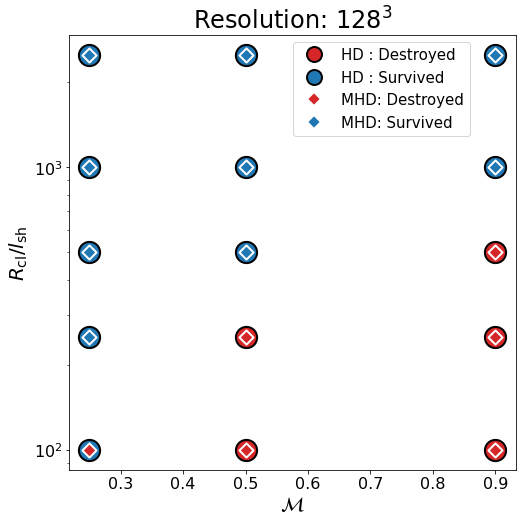

In [9]:
plt.figure()

for i_s in range(len(survival)):

    if MHD_flag_list[i_s]:
        plt.scatter(Mach_list[i_s], R_list[i_s], \
            edgecolor='w', label='MHD', linewidth=2,\
            color=surv_col[i_s], marker='D', s=MHD_size[i_s], zorder=MHD_zord[i_s])

    else:
        plt.scatter(Mach_list[i_s], R_list[i_s], \
            edgecolor='k', label='HD', linewidth=2,\
            color=surv_col[i_s], marker='o', s=MHD_size[i_s], zorder=MHD_zord[i_s])

plt.yscale('log')
# plt.xscale('log')

plt.xlabel(r'$\mathcal{M}$')
plt.ylabel(r'$R_{\rm cl}/l_{\rm sh}$')

plt.title(f"Resolution: {res_list[0]}"+r'$^{3}$')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='HD : Destroyed',
                          markerfacecolor='tab:red', markersize=15, markeredgewidth=2, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='w', label='HD : Survived ',
                          markerfacecolor='tab:blue', markersize=15, markeredgewidth=2, markeredgecolor='k'),
                   Line2D([0], [0], marker='D', color='w', label='MHD: Destroyed',
                          markerfacecolor='tab:red', markersize=10, markeredgewidth=2, markeredgecolor='w'),
                   Line2D([0], [0], marker='D', color='w', label='MHD: Survived ',
                          markerfacecolor='tab:blue', markersize=10, markeredgewidth=2, markeredgecolor='w')]

plt.legend(handles=legend_elements, bbox_to_anchor=(0.7,0.75))
# plt.legend()

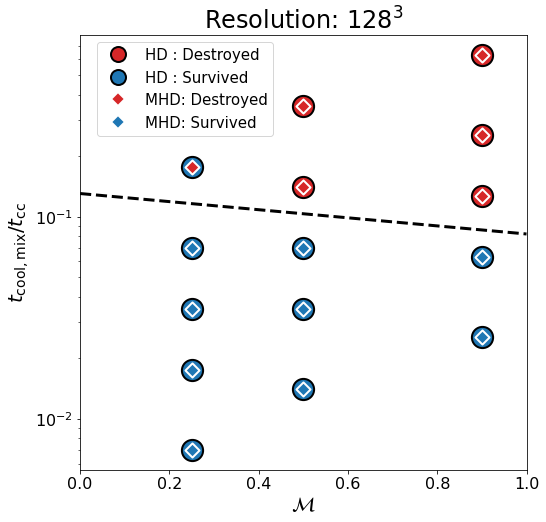

In [25]:
plt.figure()

t_cc = np.sqrt(ps.cloud_chi)*np.array(R_list)*ps.l_sh/(np.array(Mach_list)*vt.cs_calc(ps.T_hot_req,ps.mu))

tcool_mix_tcc = ps.t_cool_mix/t_cc

for i_s in range(len(survival)):

    if MHD_flag_list[i_s]:
        plt.scatter(Mach_list[i_s], tcool_mix_tcc[i_s], \
            edgecolor='w', label='MHD', linewidth=2,\
            color=surv_col[i_s], marker='D', s=MHD_size[i_s], zorder=MHD_zord[i_s])

    else:
        plt.scatter(Mach_list[i_s], tcool_mix_tcc[i_s], \
            edgecolor='k', label='HD', linewidth=2,\
            color=surv_col[i_s], marker='o', s=MHD_size[i_s], zorder=MHD_zord[i_s])

x_line = np.linspace(0,1.0,num=100)
plt.plot(x_line,(0.13)*(10**(-1/5*x_line)),linestyle='dashed',color='k')

plt.yscale('log')
# plt.xscale('log')

plt.xlabel(r'$\mathcal{M}$')
plt.ylabel(r'$t_{\rm cool,mix}/t_{\rm cc}$')

plt.xlim(0,1)

plt.title(f"Resolution: {res_list[0]}"+r'$^{3}$')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='HD : Destroyed',
                          markerfacecolor='tab:red', markersize=15, markeredgewidth=2, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='w', label='HD : Survived ',
                          markerfacecolor='tab:blue', markersize=15, markeredgewidth=2, markeredgecolor='k'),
                   Line2D([0], [0], marker='D', color='w', label='MHD: Destroyed',
                          markerfacecolor='tab:red', markersize=10, markeredgewidth=2, markeredgecolor='w'),
                   Line2D([0], [0], marker='D', color='w', label='MHD: Survived ',
                          markerfacecolor='tab:blue', markersize=10, markeredgewidth=2, markeredgecolor='w')]

plt.legend(handles=legend_elements, bbox_to_anchor=(0.45,0.75))
# plt.legend()

In [ ]:
import matplotlib as mt
import scipy.signal as sg
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import linregress

# beta_list = np.array([1,2,5,10,100,1000])
beta_list = np.array([100])
Rlsh_list = np.array([0,0,500,0,0])
# Rlsh_list = np.array([100,250,500,1000,2500])
# Rlsh_list = np.array([100,750,1000,2500])
# res_list  = np.array([128,256,512])
# res_list  = np.array([128])
res_list  = np.array([256])
# res_list  = np.array([64])
# res_list  = np.array([512])

v_turb_sim = np.zeros(np.size(Rlsh_list))

# cmap_name = 'viridis'
cmap_name = 'Paired'

cmap = mt.cm.get_cmap(cmap_name)

# cb_qnt = np.scopy(ps.dedt)
cb_qnt = np.copy(Rlsh_list)

# line_col = cmap(np.log10(beta_list)/np.log10(beta_list).max())
line_col = cmap(cb_qnt/cb_qnt.max())

fig1, ax1 = plt.subplots(1,1,figsize=(10,10))
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
fig3, ax3 = plt.subplots(1,1,figsize=(10,10))
fig4, ax4 = plt.subplots(1,1,figsize=(10,10))
fig5, ax5 = plt.subplots(1,1,figsize=(10,10))

file_list = ['hydro']
# file_list = ['mhd']#,'hydro']
# file_list = ['mhd','hydro']
rseed_list = [3]
linestyle_list = ['solid','dashed']
# linestyle_list = ['dashed','solid']

marker_list = ['X','o','D','^','v']

data_count = 0

for i_fl,file_name in enumerate(file_list):
    for i_b, beta in enumerate(beta_list):
        for i_r, Rlsh in enumerate(Rlsh_list):
            for res in res_list:
                for rseed in rseed_list:

                    if file_name == 'mhd':
                        if Rlsh == 2500:
                            file_path = f'newpgen_para_scan_Rlsh0_{Rlsh}_res0_{res}_rseed_{rseed}_beta_{beta}_n0064/Turb.hst'
                        else:
                            file_path = f'newpgen_para_scan_Rlsh{i_r}_{Rlsh}_res0_{res}_rseed_{rseed}_beta_{beta}_n0064/Turb.hst'
                        MHD_flag  = True
                    else:
                        if Rlsh == 2500:
                            file_path = f'para_scan_Rlsh0_{Rlsh}_res0_{res}_rseed_{rseed}_hydro_n0064/Turb.hst'
                        else:
                            file_path = f'para_scan_Rlsh{i_r}_{Rlsh}_res0_{res}_rseed_{rseed}_hydro_n0064/Turb.hst'
                        MHD_flag  = False


                    print(file_path,res**3,MHD_flag)


                    try:
                        hst = hst_data(file_path,res**3,MHD_flag)
                    except:
                        print(f'{file_path} does not exist !')
                        break



                    v_turb_tcut = 1

                    cs = vt.cs_calc(ps.T_hot_req,ps.mu)

                    # v_turb_sim[i_r]  = np.average(hst.turb_vel[-1500:]/cs)
                    # print(len(v_turb_sim), len(ps.t_eddy))

                    v_turb_sim[i_r]  = np.average(hst.turb_vel[hst.time/ps.t_eddy[i_r] > v_turb_tcut]/cs)

                    t_eddy_actual = ps.L_box[i_r]/(v_turb_sim[i_r]*cs)

                    # ax1.axvline(hst.time[-1500]/ps.t_eddy[i_r],color = line_col[i_r],linestyle='dotted')
                    
                    ax1.axvline(v_turb_tcut,color = line_col[i_r],linestyle='dotted')

                    ax1.plot(hst.time[:-1]/ps.t_eddy[i_r],hst.turb_vel[:-1]/cs, color = line_col[i_r], linestyle=linestyle_list[i_fl],\
                        label=f'R/lsh={Rlsh_list[i_r]}; rseed={rseed}; M={v_turb_sim[i_r]:.2}')
                    ax1.axhline(v_turb_sim[i_r],color=line_col[i_r], linestyle='dashed')


                    # ______________________________________________________#
                    
                    Chi = ps.cloud_chi
                    Rcl_lsh = Rlsh
                    Rcl_Lbox = ps.L_box[i_r]/ps.cloud_radius[i_r]

                    tgrow = np.vectorize(tg.tgrow)(Chi, v_turb_sim[i_r], Rcl_lsh, Rcl_Lbox, ps.t_cool_cloud)

                    Lbox_rad = np.average(ps.L_box/ps.cloud_radius)
                    r_N = res/Lbox_rad

                    dM_min = 1/(r_N**3)


                    # if MHD_flag and i_r==0:
                    #     ax2.axhline(dM_min,linestyle='dotted',color='k',label='dM_min')


                    cloud_mass = 4/3 * np.pi * (ps.cloud_radius[i_r]**3) * ps.amb_rho * ps.cloud_chi

                    # print(f'cloud_mass: {cloud_mass}')
                    
                    y_data2 = np.copy(hst.cold_gas/cloud_mass)
                    # y_data2 = np.copy(hst.cold_gas)
                    # y_data2 = sg.savgol_filter(y_data2, window_length=51, polyorder=3)

                    x_data2 = hst.time/ps.t_eddy[i_r]
                
                    y_data2 = y_data2[x_data2>7]
                    x_data2 = x_data2[x_data2>7]
                    
                    window_size = 35

                    y_data2 = y_data2[x_data2<11]
                    x_data2 = x_data2[x_data2<11]

                    if len(y_data2)<=window_size:
                        break
                    
                    y_data2_unsmooth = y_data2/(y_data2[0])
                    y_data2          = np.copy(y_data2_unsmooth)
                    # x_data2 = x_data2[y_data2>1e-3]
                    # y_data2 = y_data2[y_data2>1e-3]

                    # x_data2 = x_data2[y_data2<10]
                    # y_data2 = y_data2[y_data2<10]

                    # y_data2 = sg.savgol_filter(y_data2, window_length=window_size, polyorder=3)
                    
                    if not(MHD_flag) and i_r==4:

                        # pass

                        y_data2 = sg.savgol_filter(y_data2, window_length=window_size, polyorder=3)
                        
                        ax2.plot(x_data2, y_data2, '-'+marker_list[i_r], markevery=15, markersize=15, markeredgecolor='k',\
                            color = line_col[i_r], linestyle=linestyle_list[i_fl],label=f'R/lsh={Rlsh_list[i_r]}', linewidth=5,\
                            zorder=-i_r)

                        # ax2.plot( x_data2, np.exp((x_data2-x_data2[0])/tgrow) , linestyle='dotted', color = line_col[i_r])

                    elif i_r==0:
                        # pass

                        y_data2 = sg.savgol_filter(y_data2, window_length=window_size, polyorder=3)

                        ax2.plot(x_data2, y_data2, '-'+marker_list[i_r], markevery=15, markersize=15, markeredgecolor='k',\
                            color = line_col[i_r], linestyle=linestyle_list[i_fl],label=f'R/lsh={Rlsh_list[i_r]}', linewidth=5,\
                            zorder=-i_r)

                    


                    #________________________________________________________#
                               

                    # print(f'tgrow: {tgrow}') 
                    
                    # m_cold = sg.savgol_filter(hst.cold_gas/cloud_mass, window_length=5, polyorder=3)
                    
                    if i_r == 4:
                        m_cold = hst.cold_gas/cloud_mass
                        
                        window_line = 3
                        window_smoo = 101
                        w_2 = int(window_line/2)

                        # m_cold = sg.savgol_filter(m_cold, window_length=window, polyorder=3)

                        d_len = len(hst.time)

                        dm = (m_cold   - np.roll(m_cold  , 1)) [1:]
                        dt = (hst.time - np.roll(hst.time, 1)) [1:]

                        m_dot = dm/dt

                        # m_dot = [linregress(hst.time[i-w_2:i+w_2+1],m_cold[i-w_2:i+w_2+1])[0] for i in range(w_2,d_len-1-w_2)]
                        # time_list = hst.time[w_2:d_len-1-w_2]
                        # m_dot = np.array(m_dot)

                        m_dot = sg.savgol_filter(m_dot, window_length=window_smoo, polyorder=3)

                        y_data3 = np.copy(m_cold[1:]/m_dot)
                        x_data3 = hst.time[1:]/ps.t_eddy[i_r]

                        y_data3 = y_data3[x_data3>7]
                        x_data3 = x_data3[x_data3>7]

                        y_data3 = y_data3[x_data3<11]
                        x_data3 = x_data3[x_data3<11]

                        y_data3 = y_data3[y_data2_unsmooth>0.5]
                        x_data3 = x_data3[y_data2_unsmooth>0.5]

                        y_data3 = y_data3[x_data3>8]
                        x_data3 = x_data3[x_data3>8]

                        # x_data3 = x_data3[np.abs(y_data3)>1e-3]
                        # y_data3 = y_data3[np.abs(y_data3)>1e-3]

                        # x_data3 = x_data3[np.abs(y_data3)<1e1]
                        # y_data3 = y_data3[np.abs(y_data3)<1e1]

                    # bins_arr = symlogspace(y_data3,n_cuts=100)

                    if i_r in [4]:
                        if file_name=='mhd':
                            # ax3.axhline(tgrow, linestyle='dashed', linewidth=5, color='tab:red',label=r'Theoretical t$_{\rm grow}$')

                        # ax3.plot(x_data3/ps.t_eddy[i_r], y_data3, color = 'tab:blue', linestyle=linestyle_list[i_fl],\
                        #     label=f'R/lsh={Rlsh_list[i_r]}; MHD: {MHD_flag}')

                            # sns.regplot(x_data3/ps.t_eddy[i_r], y_data3, marker='o',color = 'tab:blue', \
                            #     label=f'R/lsh={Rlsh_list[i_r]}; MHD: {MHD_flag}')

                            # ax3.scatter(x_data3/ps.t_eddy[i_r], y_data3, marker='.',color = 'tab:blue', s=100,\
                            #     edgecolor='k',label=f'R/lsh={Rlsh_list[i_r]}; MHD: {MHD_flag}')

                            hist = np.histogram(y_data3, bins=200)

                            x_arr = hist[1][:-1] + np.diff(hist[1])/2
                            y_arr = hist[0] * 20**(data_count)
                            y_arr[y_arr==0] = 20**(data_count) * 0.9

                            

                            # y_arr = sg.savgol_filter(y_arr, window_length=5, polyorder=3)

                            if data_count==0:
                                ax3.fill_between(x_arr,y_arr, step="pre", alpha=0.4, zorder=0)
                            else:
                                ax3.fill_between(x_arr,y_arr, 20**(data_count) * 0.9, step="pre", alpha=0.4, zorder=0)
                            ax3.step(x_arr, y_arr, label='MHD', zorder=0)

                            data_count += 1


                            ax5.plot(x_data3,y_data3,color = line_col[i_r])


                        else:
                            hist = np.histogram(y_data3, bins=200)

                            x_arr = hist[1][:-1] + np.diff(hist[1])/2
                            y_arr = hist[0] * 20**(data_count)
                            y_arr[y_arr==0] = 20**(data_count) * 0.9
                            
                            # y_arr = sg.savgol_filter(y_arr, window_length=5, polyorder=3)

                            ax3.fill_between(x_arr,y_arr, 20**(data_count) * 0.9, step="pre", alpha=0.4, zorder=-1)
                            ax3.step(x_arr, y_arr, label='HD', zorder=-1)
                            # print(hist)

                            # ax3.scatter(x_data3/ps.t_eddy[i_r], y_data3, marker='.',color = 'tab:green', s=100,\
                            #     edgecolor='k',label=f'R/lsh={Rlsh_list[i_r]}; MHD: {MHD_flag}', zorder=-1)
                    
                            data_count += 1

                            ax5.plot(x_data3,y_data3, linestyle='dashed', color = line_col[i_r])

                        if rseed==3 and file_name!='mhd':
                            ax3.axvline(tgrow, color='tab:red', label=r't$_{\rm grow}$',linestyle='dashed')

                        ax5.axhline(tgrow, color='tab:red', label=r't$_{\rm grow}$',linestyle='dashed')

                    # y_data3 = np.copy( (hst.Pth_sum) / (hst.PB_sum)  )
                    # # y_data3 = np.copy( hst.Pth_sum/res**3 )

                    # ax3.plot(hst.time/ps.t_eddy[i_r], y_data3, color = line_col[i_r], linestyle=linestyle_list[i_fl],\
                    #     label=f'R/lsh={Rlsh_list[i_r]}; rseed={rseed_list[i_fl]}; M={v_turb_sim[i_r]:.2}')


                    #________________________________________________________#
                    
                    if MHD_flag:

                        va = hst.B_abs_avg/np.sqrt(ps.amb_rho)
                        
                        y_data4 = hst.turb_vel/va

                        ax4.plot(hst.time/ps.t_eddy[i_r], y_data4, color = line_col[i_r], linestyle=linestyle_list[i_fl],\
                            label=f'R/lsh={Rlsh_list[i_r]}')


    print(v_turb_sim)

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=plt.Normalize(vmin=np.log10(cb_qnt).min(), vmax=np.log10(cb_qnt).max()))
plt.colorbar(sm, ax=ax1, label=r'log$_{10}$(R/l$_{\rm sh}$)')
# plt.colorbar(sm, ax=ax2, label=r'log$_{10}$(R/l$_{\rm sh}$)')
# plt.colorbar(sm, ax=ax3, label=r'log$_{10}$(R/l$_{\rm sh}$)')

ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='lower right')

ax1.set_ylabel(r'$\mathcal{M}$')
ax1.set_xlabel(r't/t$_{\rm eddy}$')

# ax2.set_ylim(1e-3,1e2)
# ax2.set_ylim(0.0,5)
ax2.set_xlim(7,11)
ax2.set_ylim(1e-2,1e1)

ax5.set_xlim(8,11)
ax5.set_ylim(-1,1)

# ax3.set_xlim(-10,10)
# ax3.set_xlim(7,11)
# ax3.set_xlim(2.5,4)

# ax3.set_xlim(-5,5)
# ax3.set_ylim(9e-1,1e2)

# ax2.set_xscale('log')

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('symlog')

ax3.set_xscale('symlog')

ax2.set_ylabel(r'M$_{\rm cold}$/ M$_{\rm cloud,0}$')
ax2.set_xlabel(r't/t$_{\rm eddy}$')

ax3.set_xlabel(r't$_{\rm grow}$')
ax3.set_ylabel('Frequency')

ax4.set_ylabel(r'$\mathcal{M}_{\rm a}$')
ax4.set_xlabel(r't/t$_{\rm eddy}$')

ax5.set_ylabel(r't$_{\rm grow}$')
ax5.set_xlabel(r't/t$_{\rm eddy}$')

# ax4.axhline(1.0,linestyle='dotted',color='tab:red')

# ax3.set_ylabel(r'$\beta$')
# ax3.set_xlabel(r't/t$_{\rm eddy}$')

ax1.set_title('Resolution: '+f'{res}'+r'$^3$')
# ax2.set_title('Resolution: '+f'{res}'+r'$^3$')
ax2.set_title('MHD Simulations')

# ax3.set_title(r'R$_{\rm cloud}$/l$_{\rm sh}$ = '+ f'{Rlsh_list[4]}')

# np.savetxt('beta_last_vturb',v_turb_sim)
# np.savetxt('beta_curr_vturb',v_turb_sim)

# plt.yscale('log')
